In [15]:
import numpy as np
import vtk
import matplotlib.pyplot as plt
import vtkplotlib as vpl
from vtk.util.numpy_support import vtk_to_numpy
import os
from scipy import spatial
from sklearn.decomposition import PCA

In [16]:
def readfile(filename):
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(filename)
    reader.Update()

    polydata = reader.GetOutput()

    points = polydata.GetPoints()
    array = points.GetData()
    numpy_nodes = vtk_to_numpy(array)
    #print(numpy_nodes)
    cells = polydata.GetPolys()
    nCells = cells.GetNumberOfCells()
    array = cells.GetData()
    # This holds true if all polys are of the same kind, e.g. triangles.
    assert(array.GetNumberOfValues()%nCells==0)
    nCols = array.GetNumberOfValues()//nCells
    numpy_cells = vtk_to_numpy(array)
    numpy_cells = numpy_cells.reshape((-1,nCols))
    return numpy_cells, numpy_nodes

def write_vtk(points, cell, filename):
    with open(filename, 'w') as f:
        # Write header
        f.write("# vtk DataFile Version 4.2\n")
        f.write("vtk output\n")
        f.write("ASCII\n")
        f.write("DATASET POLYDATA\n")
        
        # Write points
        num_points = len(points)
        f.write("POINTS {} float\n".format(num_points))
        for point in points:
            f.write("{} {} {}\n".format(point[0], point[1], point[2]))
        
        # Write cells
        num_cells = len(cell)
        total_num_points = np.sum(cell[:, 0])
        f.write("POLYGONS {} {}\n".format(num_cells, total_num_points + num_cells))
        for cell_indices in cell:
            num_indices = cell_indices[0]
            f.write("{} ".format(num_indices))
            for index in cell_indices[1:]:
                f.write("{} ".format(index))
            f.write("\n")

def visualize(nameOfFile):

        # Load the VTK file
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(nameOfFile)
    reader.Update()

    # Create a mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(reader.GetOutputPort())

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Create a renderer and add the actor to it
    renderer = vtk.vtkRenderer()
    renderer.AddActor(actor)

    # Create a render window and set the renderer as its active renderer
    renderWindow = vtk.vtkRenderWindow()
    renderWindow.AddRenderer(renderer)
    renderWindow.SetSize(600, 600)
    renderer.ResetCamera()

    # Create an interactor and start the visualization
    interactor = vtk.vtkRenderWindowInteractor()
    interactor.SetRenderWindow(renderWindow)
    interactor.Start()

def flatten(Shape):
    return np.concatenate((Shape[:, 0], Shape[:, 1], Shape[:, 2]))

def unflatten(Shape):
    n = len(Shape)//3
    return np.array([Shape[:n], Shape[n:2*n], Shape[2*n:]]).T

In [17]:
filepath = '../../FacesDatavtk/ImageToStl.com_1.vtk'
Tab, Tob = readfile(filepath)
Tab.shape, Tob.shape

((105694, 4), (53149, 3))

In [18]:
path = '../../FacesDatavtk/'
L = os.listdir(path)
Dataset = []
Wiring = []

for f in L :
    if 'vtk' in f :
       Tab, Tob = readfile(path+f)
       Dataset.append(Tob)
       Wiring.append(Tab)
Dataset = np.array(Dataset)

In [19]:
mean_face = np.mean(Dataset,axis = 0)
Normalized_Faces = []
Path_w = '../../Aligned_data/'

for i in range(Dataset.shape[0]):
    _, mtx, disparity = spatial.procrustes(mean_face, Dataset[i])
    Normalized_Faces.append(mtx)
    cell = Wiring[i]
    write_vtk(mtx, cell, Path_w+'Face'+str(i)+'.vtk')

Normalized_Faces = np.array(Normalized_Faces)

In [21]:
mean_face = np.mean(Normalized_Faces,axis = 0)
cell = Wiring[0]
write_vtk(mean_face, cell, Path_w+'Face'+str(10)+'.vtk')

In [20]:
path = '../Aligned_data/'
L = os.listdir(path)


visualize(path+'Face10.vtk')

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../Aligned_data/'

In [14]:
def Visualize(Faces_List=[], Wiring=[], colors=[], Scatter=[0]):
    mesh = Faces_List[0][Wiring][:, 1:]
    offset = np.zeros(mesh.shape)
    vpl.figure("Face")
    for i in range(len(Faces_List)) :
        mesh = Faces_List[i][Wiring][:, 1:] + offset
        vpl.mesh_plot(mesh, color=colors[i])
        offset[:, :, 0] += 0.01
    if Scatter[0]:
        vpl.scatter(Faces_List[0][Scatter], radius=0.0001, color='r')
    vpl.show()

for i in range(Normalized_Faces.shape[0]) :
    Visualize([Dataset[i]], Wiring[0], ['w'], np.random.randint(0, len(Normalized_Faces[0]), 50))

In [13]:
Landmarks = np.random.randint(0, len(Normalized_Faces[0]), 50)
mesh = Normalized_Faces[0][Wiring[0]][:, 1:]
vpl.scatter(Normalized_Faces[0][Landmarks], radius=0.0001, color='r')
vpl.mesh_plot(mesh, color='w')

offset = np.zeros(mesh.shape)
offset[:, :, 0] = 0.01
mesh = Normalized_Faces[9][Wiring[0]][:, 1:] + offset
vpl.mesh_plot(mesh, color='y')

vpl.show()

In [14]:
offset.shape

(105694, 3, 3)

In [15]:
Normalized_Faces.shape, Dataset.shape

((10, 53149, 3), (10, 53149, 3))

In [16]:
D = 3*Normalized_Faces.shape[1]
N = Normalized_Faces.shape[0]

Dataset = np.zeros((N, D))
for i in range(N):
    Dataset[i] = flatten(Normalized_Faces[i])

In [17]:
pca = PCA(n_components=3)
pca.fit(Dataset)
E = pca.singular_values_
print(E.shape)

(3,)


In [18]:
Y = pca.fit_transform(Dataset)

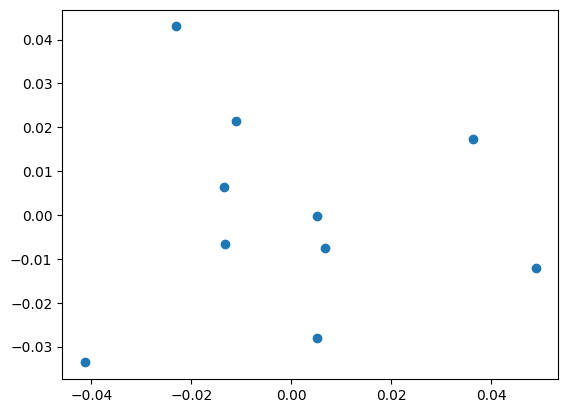

In [19]:
plt.scatter(Y[:, 0], Y[:, 1])
plt.show()

In [20]:
m1, M1 = min(Y[:, 0]), max(Y[:, 0])
m2, M2 = min(Y[:, 1]), max(Y[:, 1])
m3, M3 = min(Y[:, 2]), max(Y[:, 2])
mean = np.mean(Dataset, axis=0)
print(mean.shape)

(159447,)


In [22]:
M = max(abs(np.array([m1, M1, m2, M2, m3, M3])))
New_samples = np.random.uniform(-M, M, (100, 3))

New_shapes = pca.inverse_transform(New_samples)
for i in range(100) :
    write_vtk(unflatten(New_shapes[i]), Wiring[0], Path_w+'Face'+str(i+11)+'.vtk')
    print(np.sum((New_shapes[i]- mean)**2))

0.0015747822187980936
0.0024636144258959
0.0038455110355322198
0.00479039093416214
0.0034015663076227627
0.0005432575933967384
0.0010586163417482051
0.0012134519689424418
0.004898275983223684
0.004521522344665397
0.002379676244269683
0.0015192253578548698
0.0006679615147095393
0.0019006123347023336
0.002023728073230411
0.0029053827419466215
0.0011849161416464399
0.0017603593588453657
0.002447890194148209
0.0022821205848620133
0.0028185870342350905
0.001178429777227304
0.0039709577114721
0.0026357799507766965
0.003217065315849456
0.0034622250028639827
0.003529825517570633
0.0010335749114118243
0.0026989568106107636
0.0029261218964006888
0.0029497611657334014
0.0016007008578225622
0.004786517161258636
0.002034931570989728
0.00249092796349258
0.001325461961031607
0.001417185060967954
0.004863481474759333
0.0030853819935937965
0.001646127651412966
0.003060474303232465
0.00299635290046002
0.004171839146226611
0.002679233104138801
0.003351948923737776
0.0010082368784801294
0.0036158659648946

In [23]:
from IPython.display import clear_output

def Construct_dataset(path) :
    L = os.listdir(path)
    Dataset = []
    for i in range(len(L)) :
        if 'vtk' in L[i] :
            Tab, Tob = readfile(path+L[i])
            Dataset.append(flatten(Tob))
        print('Progress : '+str(round(i/len(L)*100, 1))+str(' %'))

    return np.array(Dataset)

In [24]:
path = '../Aligned_data/'
Dataset = Construct_dataset(path)

Progress : 0.0 %
Progress : 0.9 %
Progress : 1.8 %
Progress : 2.7 %
Progress : 3.6 %
Progress : 4.5 %
Progress : 5.4 %
Progress : 6.3 %
Progress : 7.2 %
Progress : 8.1 %
Progress : 9.0 %
Progress : 9.9 %
Progress : 10.8 %
Progress : 11.7 %
Progress : 12.6 %
Progress : 13.5 %
Progress : 14.4 %
Progress : 15.3 %
Progress : 16.2 %
Progress : 17.1 %
Progress : 18.0 %
Progress : 18.9 %
Progress : 19.8 %
Progress : 20.7 %
Progress : 21.6 %
Progress : 22.5 %
Progress : 23.4 %
Progress : 24.3 %
Progress : 25.2 %
Progress : 26.1 %
Progress : 27.0 %
Progress : 27.9 %
Progress : 28.8 %
Progress : 29.7 %
Progress : 30.6 %
Progress : 31.5 %
Progress : 32.4 %
Progress : 33.3 %
Progress : 34.2 %
Progress : 35.1 %
Progress : 36.0 %
Progress : 36.9 %
Progress : 37.8 %
Progress : 38.7 %
Progress : 39.6 %
Progress : 40.5 %
Progress : 41.4 %
Progress : 42.3 %
Progress : 43.2 %
Progress : 44.1 %
Progress : 45.0 %
Progress : 45.9 %
Progress : 46.8 %
Progress : 47.7 %
Progress : 48.6 %
Progress : 49.5 %
Prog

In [25]:
T = int(0.9*Dataset.shape[0])
Train_data = Dataset[:T, :]
Test_data = Dataset[T:, :]

Train_data.shape, Test_data.shape

((99, 159447), (12, 159447))

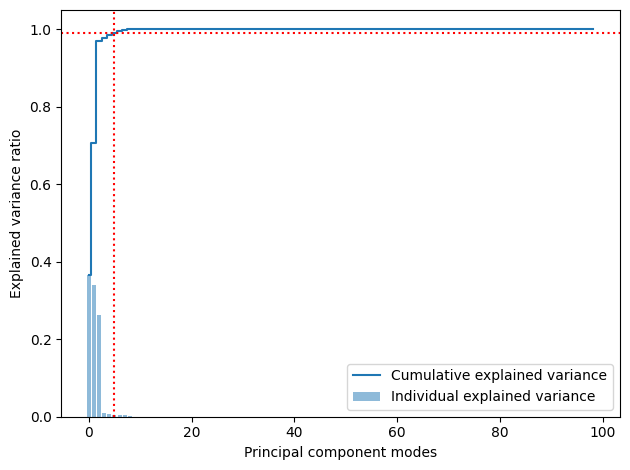

the number of significant PCA modes : 6


In [26]:
def PCA_analysis(data) :   
    pca = PCA(n_components=len(data))
    pca.fit(data)
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)

    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component modes')
    plt.legend(loc='best')
    plt.tight_layout()

    N = 0
    for i in range(len(cum_sum_eigenvalues)):
        if cum_sum_eigenvalues[i]>= 0.99*cum_sum_eigenvalues[-1] :
            plt.axhline(y = cum_sum_eigenvalues[i], color = 'r', linestyle = ':')
            plt.axvline(x = i, color = 'r', linestyle = ':')
            N = i+1
            break
    plt.show()
    print('the number of significant PCA modes : ' + str(N))

PCA_analysis(Train_data)

In [24]:
D = Train_data.shape[1]//3 
N = Train_data.shape[0]

Control_pts = np.random.randint(0, D, 0)

#P = range(1, 5000, 100)

Visualize([unflatten(Train_data[0])], Wiring[0], ['w'], Control_pts)

In [25]:
F = np.zeros(len(Control_pts)*3)

i = 0
while i < len(Control_pts) :
    F[3*i], F[3*i+1], F[3*i+2]= Control_pts[i], Control_pts[i]+D, Control_pts[i]+2*D
    i += 1

F = F.astype(int)

In [34]:
mean = np.mean(Train_data, axis=0)
X = (Train_data[:, :] - mean)
u, s, vh = np.linalg.svd(X.T, full_matrices=False)

#p = s.shape[0]
p=20
u = u[:, :p]
s = s[:p]
vh = vh[:p, :p]
u.shape, s.shape, vh.shape

((159447, 40), (40,), (40, 40))

In [35]:
X_new = u[F, :] @ np.diag(s)
u_new, s_new, vh_new = np.linalg.svd(X_new, full_matrices=False)
u_new.shape, s_new.shape, vh_new.shape

((60, 40), (40,), (40, 40))

In [36]:
from copy import deepcopy


Test = (np.min(Test_data)/600)*np.random.normal(0, 1, Test_data.shape) + Test_data
X_test = (deepcopy(Test) - mean).T
X_test.shape

X_test_n = deepcopy(Test).T

In [37]:
E = []
for i in range(1, 5) :

    error = []
    C_opt = vh_new.T @ np.diag(s_new/(s_new**2+0.00001)) @ u_new.T @ X_test[F, i]
    Model = u @ np.diag(s) @ C_opt + mean
    error.append((np.linalg.norm(Model-X_test[:, i])/np.linalg.norm(mean-X_test[:, i]))**2)
    Visualize([unflatten(Test_data[i]), unflatten(mean), unflatten(Model)], Wiring[0], ['w', 'w', 'w'], Control_pts)

    for j in range(50) :

        Coords = F[3*j:3*j+3]
        Copt = np.linalg.inv(u[Coords, :] @ np.diag(s) @ (u[Coords, :].T)) @ (X_test_n[:, i][Coords]- Model[Coords])
        Model += u @ np.diag(s) @ (u[Coords, :].T) @ Copt 

        error.append((np.linalg.norm(Model-X_test[:, i])/np.linalg.norm(mean-X_test[:, i]))**2)
    
    E.append(error)
    
    
    
plt.plot(E)
plt.show()

KeyboardInterrupt: 

In [104]:
Train_data.shape, Test_data.shape

((99, 159447), (12, 159447))

Train accuracy : 1.0420130765979139 %
Test accuracy : 1.2443363929702247 %
Train accuracy : 1.2315698009003486 %
Test accuracy : 1.3170905239304016 %
Train accuracy : 1.300105043086456 %
Test accuracy : 1.3176339535374104 %
Train accuracy : 1.3810015171649768 %
Test accuracy : 1.3599249076186462 %
Train accuracy : 1.3562518717397551 %
Test accuracy : 1.3297259904632661 %
Train accuracy : 1.4038089114092653 %
Test accuracy : 1.380588808021188 %
Train accuracy : 1.4356412581485254 %
Test accuracy : 1.3609842978338016 %
Train accuracy : 1.453355410458887 %
Test accuracy : 1.341425347719079 %
Train accuracy : 1.4508052190196565 %
Test accuracy : 1.397158623672436 %
Train accuracy : 1.486805477820107 %
Test accuracy : 1.4073176093030775 %
Train accuracy : 1.4879826560170168 %
Test accuracy : 1.3671613397393043 %
Train accuracy : 1.479211539535478 %
Test accuracy : 1.3587667738876776 %
Train accuracy : 1.4929941329702305 %
Test accuracy : 1.3700492199249943 %
Train accuracy : 1.4890152970435

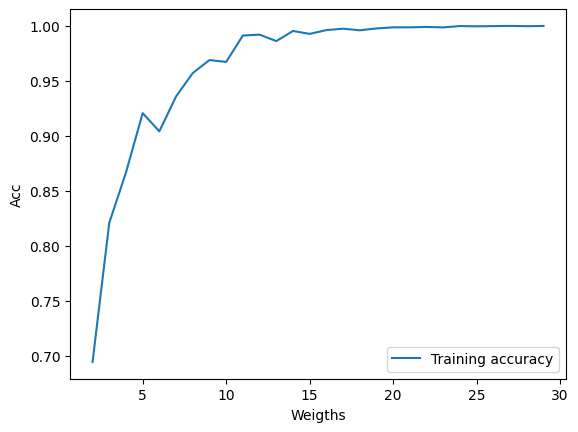

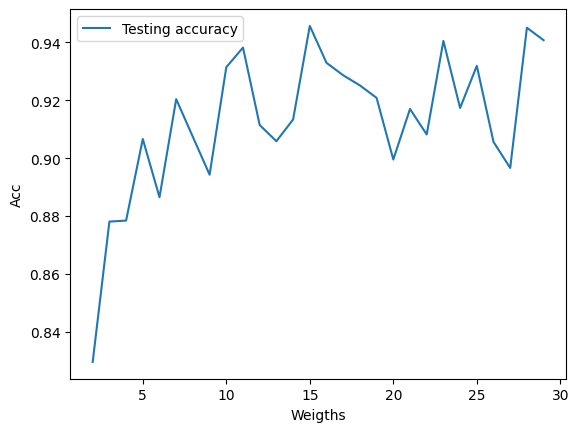

In [161]:
from time import time 

def decompose(Shape, u):
        Coefs = np.zeros(u.shape[1])
        for i in range(u.shape[1]) :
            Coefs[i] = np.dot(Shape, u[:, i])/(np.linalg.norm(u[:, i]))**2
        return Coefs

def similarity(Model, Target, mean, u) :
    #print(Model.shape, Target.shape, mean.shape, u.shape)
    return 1 - (np.linalg.norm(decompose(Model, u)-Target)/np.linalg.norm(mean-Target))**2

def Reconstruct(Face, mean, Points, mean_dec, Dx1, Mx1, Mx2) :

    #E = []
    Face_c = Face-mean
    #C_opt = vh_new.T @ np.diag(s_new/(s_new**2+0.0001)) @ u_new.T @ Face_c[Points]
    #Model = u @ np.diag(s) @ C_opt + mean
    Target = decompose(Face, u)
    
    C_opt = Mx1 @ Face_c[Points]
    Model = Mx2 @ C_opt + mean

    #E.append(similarity(Model, Target, mean_dec, u))

    for j in range(len(Points)//3) :
        Coords = Points[3*j:3*j+3]
        Copt = Dx1[j][0] @ (Face[:][Coords]- Model[Coords])
        Model += Dx1[j][1]  @ Copt 
        #E.append(similarity(Model, Target, mean_dec, u))
    
    error = similarity(Model, Target, mean_dec, u)
    #plt.plot(E)
    #plt.show()
    return Model, error


start = time()
Test = (np.min(Test_data)/600)*np.random.normal(0, 1, Test_data.shape) + Test_data

mean_dec = decompose(mean, u)

def init(Dim) :

    Control_pts = np.random.randint(0, D, Dim)

    F = np.zeros(len(Control_pts)*3)

    i = 0
    while i < len(Control_pts) :
        F[3*i], F[3*i+1], F[3*i+2]= Control_pts[i], Control_pts[i]+D, Control_pts[i]+2*D
        i += 1

    F = F.astype(int)

    Dx1 = dict()

    for j in range(50) :
        Coords = F[3*j:3*j+3]
        Dx1[j] = [np.linalg.inv(u[Coords, :] @ np.diag(s) @ (u[Coords, :].T)), u @ np.diag(s) @ (u[Coords, :].T)]

    return Dx1, Control_pts, F

Weights = range(2, 30)


Train_A = []
Test_A = []
for Dim in Weights : 

    a1 = 0
    a2 = 0 
    for k in range(6) :
        train_acc = 0

        Dx1, Control_pts, F, = init(Dim)

        X_new = u[F, :] @ np.diag(s)
        u_new, s_new, vh_new = np.linalg.svd(X_new, full_matrices=False)

        w = 0.0001
        Mx1 = vh_new.T @ np.diag(s_new/(s_new**2+w)) @ u_new.T 
        Mx2 = u @ np.diag(s)
        for i in range(5) :
            _, acc = Reconstruct(Train_data[i], mean, F, mean_dec, Dx1, Mx1, Mx2)
            train_acc += acc

        a1 += train_acc/(5)
        
        test_acc = 0
        for i in range(5) :
            _, acc = Reconstruct(Test[i], mean, F, mean_dec, Dx1, Mx1, Mx2)
            test_acc += acc
        
        a2 += test_acc/5
    Train_A.append(a1/6)
    Test_A.append(a2/6)
    print("Train accuracy : "+str(a1/4)+' %')
    print("Test accuracy : "+str(a2/4)+' %')

plt.plot(Weights, Train_A, label="Training accuracy")
plt.xlabel("Weigths")
plt.ylabel("Acc")
plt.legend()
plt.show()
plt.plot(Weights, Test_A, label="Testing accuracy")
plt.xlabel("Weigths")
plt.ylabel("Acc")
plt.legend()
plt.show()

#Visualize([unflatten(Test_data[1]), unflatten(mean), unflatten(Model)], Wiring[0], ['w', 'w', 'w'], Control_pts)

In [ ]:
Weights = range(3, 21)


Train_A = []
Test_A = []
for Dim in Weights : 


    mean = np.mean(Train_data, axis=0)
    X = (Train_data[:, :] - mean)
    u, s, vh = np.linalg.svd(X.T, full_matrices=False)

    #p = s.shape[0]
    p=Dim
    u = u[:, :p]
    s = s[:p]
    vh = vh[:p, :p]

    a1 = 0
    a2 = 0 
    for k in range(6) :
        train_acc = 0

        Dx1, Control_pts, F, = init(20)

        X_new = u[F, :] @ np.diag(s)
        u_new, s_new, vh_new = np.linalg.svd(X_new, full_matrices=False)

        w = 0.0001
        Mx1 = vh_new.T @ np.diag(s_new/(s_new**2+w)) @ u_new.T 
        Mx2 = u @ np.diag(s)
        for i in range(5) :
            _, acc = Reconstruct(Train_data[i], mean, F, mean_dec, Dx1, Mx1, Mx2)
            train_acc += acc

        a1 += train_acc/(5)
        
        test_acc = 0
        for i in range(5) :
            _, acc = Reconstruct(Test[i], mean, F, mean_dec, Dx1, Mx1, Mx2)
            test_acc += acc
        
        a2 += test_acc/5
    Train_A.append(a1/6)
    Test_A.append(a2/6)
    print("Train accuracy : "+str(a1/4)+' %')
    print("Test accuracy : "+str(a2/4)+' %')

plt.plot(Weights, Train_A, label="Training accuracy")
plt.xlabel("Weigths")
plt.ylabel("Acc")
plt.legend()
plt.show()
plt.plot(Weights, Test_A, label="Testing accuracy")
plt.xlabel("Weigths")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [68]:
Visualize([unflatten(Test_data[1]), unflatten(mean)], Wiring[0], ['w', 'w'], Control_pts)

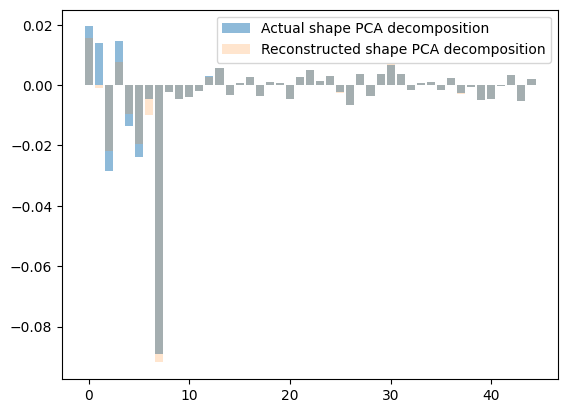

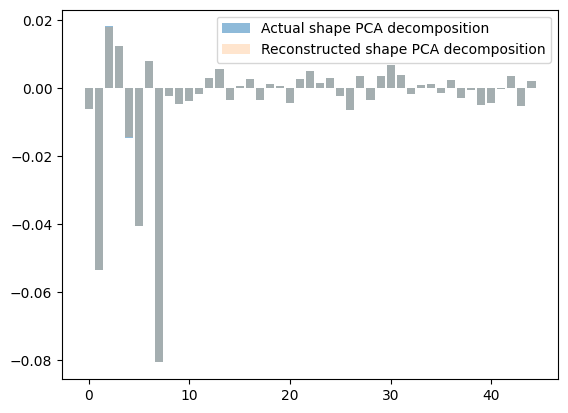

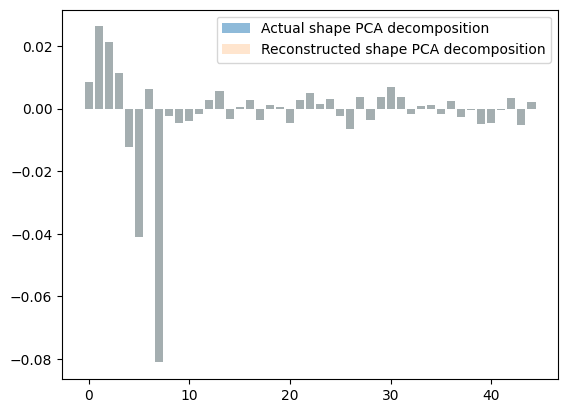

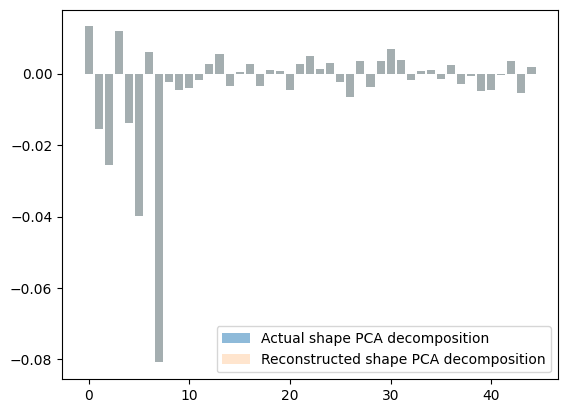

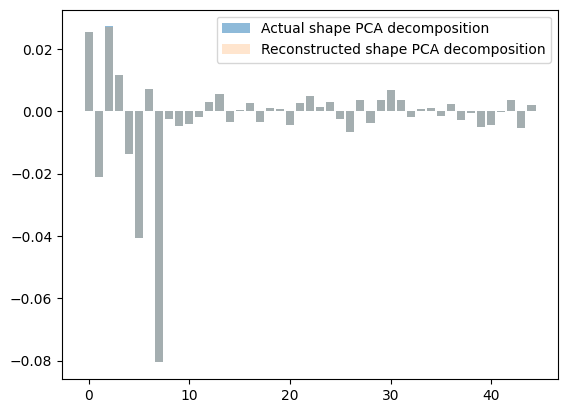

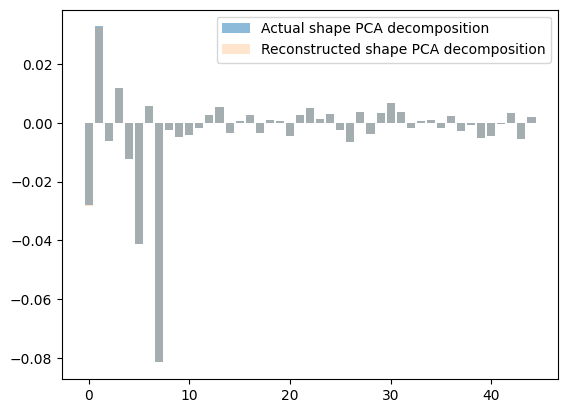

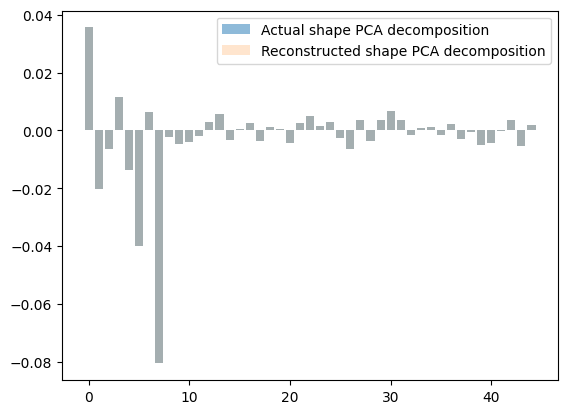

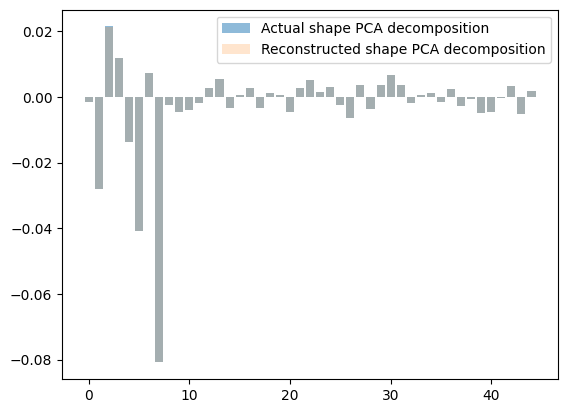

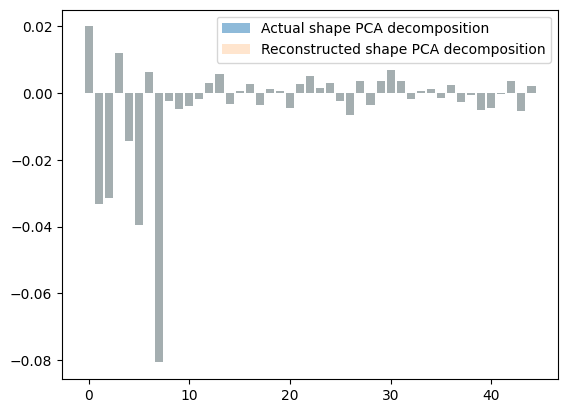

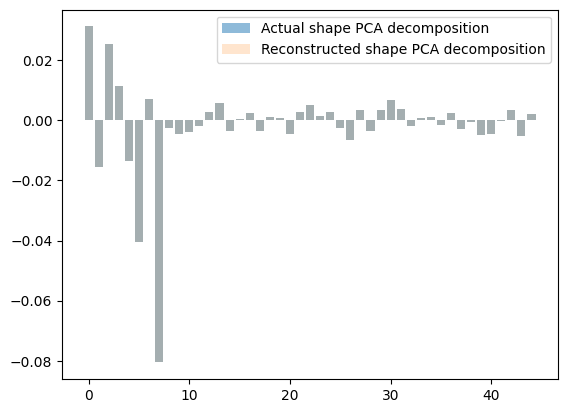

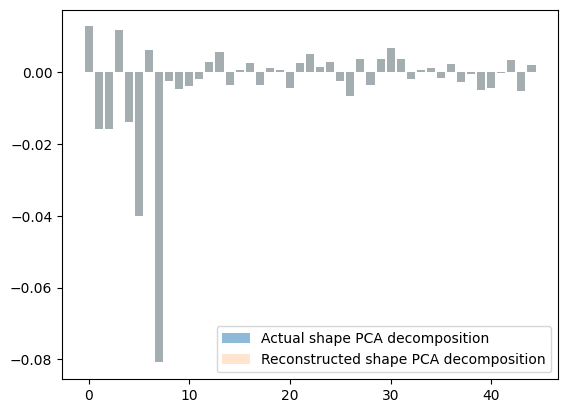

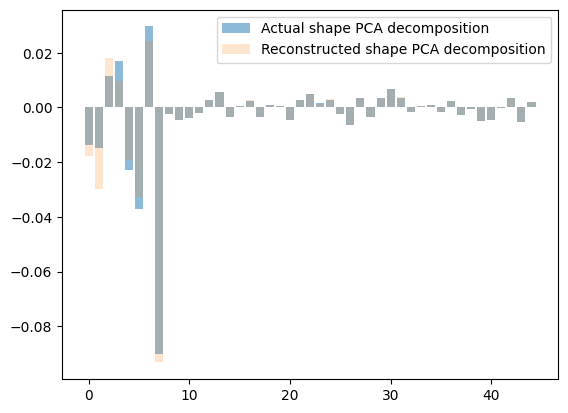

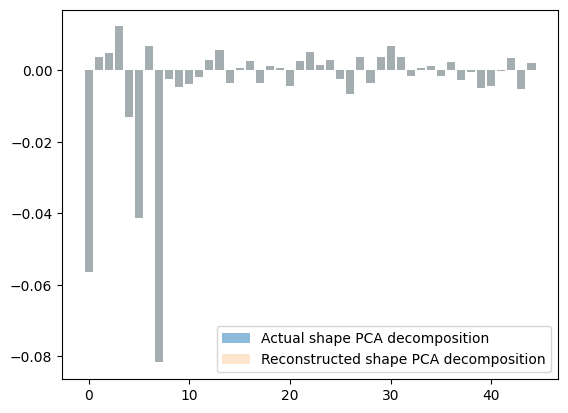

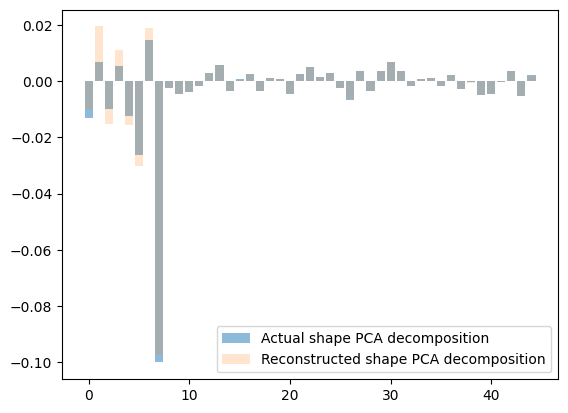

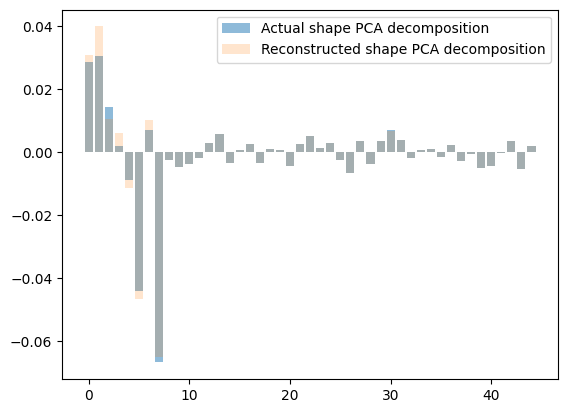

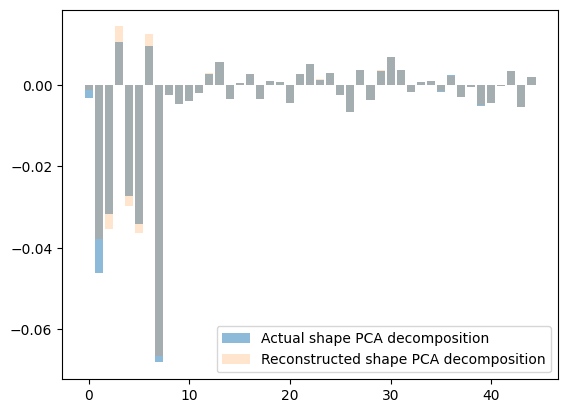

In [89]:
for i in range(Test_data.shape[0]) :
    Shape = Test_data[i]
    Model = Reconstruct(Shape, mean, F)

    Coefs1 = decompose(Shape, u)
    Coefs2 = decompose(Model, u)

    plt.bar(range(0,len(Coefs1)), Coefs1, alpha=0.5, align='center', label='Actual shape PCA decomposition')
    plt.bar(range(0,len(Coefs2)), Coefs2, alpha=0.2, align='center', label='Reconstructed shape PCA decomposition')
    plt.legend()
    plt.show()

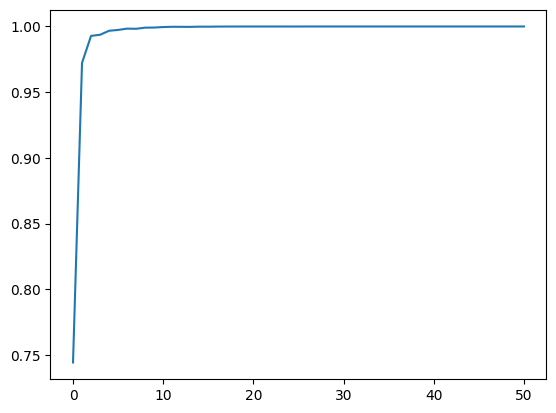

In [70]:
Shape = Test_data[-2]
Model = Reconstruct(Shape, mean, F)

Visualize([unflatten(Shape), unflatten(mean), unflatten(Model)], Wiring[0], ['w', 'w', 'w'], Control_pts)